# class implementation

In [130]:
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
from random import choices
%matplotlib inline
%config InlineBackend.figure_format ='svg'
from PIL import Image
import requests
from tqdm import trange

In [131]:
class WFC:
    def __init__(self, imPath, imDims = None, out_dims = (80, 100)):
        self._imPath = imPath
        self._imDims = imDims
        self._load_im_to_bitmap()
        
        self._preprocess_bitmap()
            
        self.out_dims = out_dims
        
        #create "wave" vec
        self.W = np.ones((*out_dims, len(self.tile_counts)), dtype = "bool") 
        
        #create entropy vec
        self.H = np.ones((out_dims), dtype = "float")
        self.H[:,:] = len(self.tile_counts)
        
        self.output_image = np.zeros((*out_dims, 3), dtype = "uint8")
        
        
    def _load_im_to_bitmap(self):
        """
        Load input image to numpy array.
        
        If imDims (height, width) is set, then resize image
        to the correct resolution (one pixel <=> one color)
        """
        with Image.open(self._imPath) as im:
            if self._imDims: # resize to correct resolutiom
                bitmap = np.asarray(im.resize(self._imDims, 
                                    resample = Image.Resampling.NEAREST))
            else:
                bitmap = np.asarray(im)
                
        self.bitmap = bitmap
        
        
        
    def _preprocess_bitmap(self):
        """
        Scan (3,3) tiles in the input bitmap, 
        and compute adjecancy rules.
        """
        
        # scan (3,3,3) patterns in input bitmap 
        
        aa = np.hstack([self.bitmap,self.bitmap])
        aaaa = np.vstack([aa,aa]) #edge overflow
        self.tiles = []

        for x in range(self.bitmap.shape[0]):
            for y in range(self.bitmap.shape[1]): # window upper left at (x,y)
                tile = aaaa[x:x+3,y:y+3,:]
                self.tiles.append(tile)

        
        self.tile_hashes = [hash(t.data.tobytes()) for t in self.tiles]  
        self.tile_counts = Counter(self.tile_hashes)
        self.get_tile_from_hash = {h : t for h, t in zip(self.tile_hashes, self.tiles)}
        self.nr_tiles = len(self.tile_counts)

        # A : (melyik csempe, melyik szomszeddal, melyik iranyban) = szomszedos-e?
        self.A = np.zeros((self.nr_tiles,self.nr_tiles,4), dtype = "bool")

        for t_idx, t_id in enumerate(self.tile_counts):
            for nb_idx, nb_id in enumerate(self.tile_counts):
                a = self.get_tile_from_hash[t_id]
                b = self.get_tile_from_hash[nb_id]
                
                # 0. irany : nyugat, bal 
                if np.all(a[:,:2,:] == b[:,1:,:]): #ha atfedesben van
                    self.A[t_idx, nb_idx, 0] = True

                # 1. irany : kelet, jobb 
                if np.all(a[:,1:,:] == b[:,:2,:]): 
                    self.A[t_idx, nb_idx, 1] = True

                # 2. irany : eszak, fel 
                if np.all(a[:2,:,:] == b[1:,:,:]): 
                    self.A[t_idx, nb_idx, 2] = True

                # 3. irany : del, le 
                if np.all(a[1:,:,:] == b[:2,:,:]): 
                    self.A[t_idx, nb_idx, 3] = True
                    
                    
        #tile hash to indices dict
        self.id_to_idx = { id : n  for n, id in enumerate(self.tile_counts.keys()) }

                    
    def _observation(self):
        H, W = self.H, self.W
        """
        1.find min entropy
        2.choose from possible tiles, according to input deviation

        returns (which index, what color)
        """
        #find min entropy
        i,j = np.unravel_index(H.argmin(), H.shape) # find argmin indices

        #choose from possible tiles, according to input deviation
        population = []
        weights = []
        for b, t_id in zip(W[i,j], self.id_to_idx):
            if b: # ha ez meg megengedett csempe
                population.append(t_id)
                weights.append(self.tile_counts[t_id])


        return (i,j), choices(population, weights=weights)[0]

    
    
    def _collapse(self):
        """
        1. get min entropy tile
        2. update W an H
        3. color output_image

        return the collapsed index (i,j)
        """
        
        #get min entropy tile 
        (i,j), t_id = self._observation() 

        #update W at this tile
        self.W[i,j, :] = False
        self.W[i,j, self.id_to_idx[t_id]] = True

        # set entropy to inf for the collapsed cell
        self.H[i,j] = float("inf")

        # color the (i,j) pixel in the output_image
        # with the left upper color of the coosen tile.
        self.output_image[i,j, :] = self.get_tile_from_hash[t_id][0,0,:] #

        return (i,j)
    
    
    def _propagation(self, i,j):
        """
        start updating W from (i,j) using Adjacency_rules
        """

        stack = {(i,j)} #start from last recent collapsed cell
        while stack:
            idx_current = stack.pop() # a kozepso, akinek a szomszedait vizsgaljuk

            w,h = self.W.shape[1], self.W.shape[0]
            i,j = idx_current

            nbr_idxs = [(i, (j-1) % w), # 0. irany : nyugat, bal 
                        (i, (j+1) % w), # 1. irany : kelet, jobb
                        ((i-1) % h, j), # 2. irany : eszak, fel
                        ((i+1) % h, j)  # 3. irany : del, le
                        ]

            for dir, idx_nb in enumerate(nbr_idxs):

                if self.H[idx_nb] != float("inf"): #csak ha meg nem collapsed a nb
                    possible_tiles_at_current = self.W[idx_current]

                    possible_nbrs_at_dir = np.any(self.A[possible_tiles_at_current, :, dir],
                                                    axis = 0)
                    x,y = idx_nb
                    available = self.W[x,y, :]

                    # check if the neighbour is need to be updated at all
                    # available is not subset of possible_nbrs_at_dir ?
                    if not ( np.all( possible_nbrs_at_dir[available] )):

                        intersection = possible_nbrs_at_dir & available

                        if np.sum(intersection) == 0:
                            print("nincs lehetseges csempe")
                            return
                        else:
                            #update wave function at idx_nb
                            self.W[x,y, :] = intersection

                            # add nbr to stack
                            stack.add(idx_nb)
                            
                            
    def _update_entropy(self):
        """
        update H from the new W.
        """
        finished = self.H == float("inf")

        self.H[:,:] = np.sum(self.W, axis = 2) 
        self.H[:,:] += 0.1 * np.random.randn(*self.H.shape)

        self.H[finished] = float("inf")
        
    def run(self):
        for t in trange(self.out_dims[0] * self.out_dims[1]):
            collapsed_idx = self._collapse()
            self._propagation(*collapsed_idx)
            self._update_entropy()

#             if t % 100 == 0:
#                 # plt.imshow(output_image)
#                 # plt.savefig(f"gif/out_{t}.png")
#                 Image.fromarray(output_image).save(f"gif/out_{t}.png")


#             Image.fromarray(output_image).save(f"gif/out_{8000}.png")

In [132]:
w = WFC("images/flowers.png", imDims = (15,23))

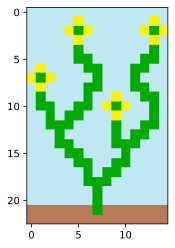

In [133]:
plt.imshow(w.bitmap)

In [134]:
w.run()

 37%|██████████████▏                       | 2994/8000 [00:10<00:09, 516.06it/s]

nincs lehetseges csempe
nincs lehetseges csempe
nincs lehetseges csempe
nincs lehetseges csempe
nincs lehetseges csempe
nincs lehetseges csempe
nincs lehetseges csempe
nincs lehetseges csempe


 98%|█████████████████████████████████████▎| 7859/8000 [00:20<00:00, 673.08it/s]

nincs lehetseges csempe
nincs lehetseges csempe
nincs lehetseges csempe
nincs lehetseges csempe
nincs lehetseges csempe


100%|██████████████████████████████████████| 8000/8000 [00:20<00:00, 390.51it/s]

nincs lehetseges csempe
nincs lehetseges csempe
nincs lehetseges csempe
nincs lehetseges csempe
nincs lehetseges csempe
nincs lehetseges csempe
nincs lehetseges csempe
nincs lehetseges csempe
nincs lehetseges csempe


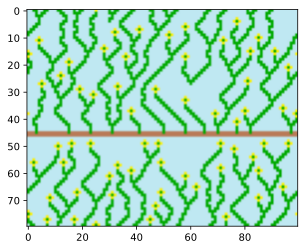

In [135]:
plt.imshow(w.output_image)

## implementation
[alg. lepesek](https://discourse.processing.org/t/wave-collapse-function-algorithm-in-processing/12983)


[interaktiv alg](https://oskarstalberg.com/game/wave/wave.html)

In [1]:
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
from random import choices
%matplotlib inline
%config InlineBackend.figure_format ='svg'
from PIL import Image
import requests

### import bitmap

### load bitmap from url

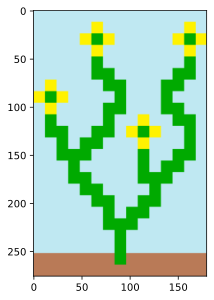

In [144]:
circle_url = "https://github.com/BitwiseSupernova/wave-function-collapse/raw/master/waveSource.png"
big_flower_url = "https://www.gridbugs.org/images/wave-function-collapse/flower-banner-scaled.png"
flower_url = "https://www.gridbugs.org/images/wave-function-collapse/flowers.png"



im = Image.open(requests.get(flower_url, stream=True).raw)
bitmap = np.asarray(im)
plt.imshow(bitmap)

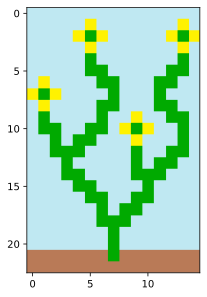

In [153]:
imr = im.resize((15,23), resample=Image.NEAREST)
bitmapr = np.asarray(imr)
plt.imshow(bitmapr)

In [154]:
bitmap = bitmapr

### load bitmap from file


In [107]:
bitmap_fp = "flowers.png"
# bitmap_fp = "circle.png"
# bitmap_fp = "flower-banner-scaled.png"
with Image.open(bitmap_fp) as im:
    bitmap = np.asarray(im)

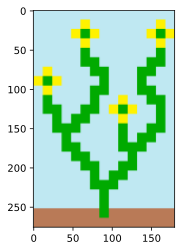

In [108]:
plt.imshow(np.asarray(Image.open(bitmap_fp)))

In [109]:
bitmap = np.asarray(  Image.open(bitmap_fp).resize((15,23), resample = Image.Resampling.NEAREST) )

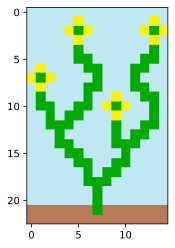

In [110]:
plt.imshow(  bitmap  )

In [111]:
bitmap.shape

(23, 15, 3)

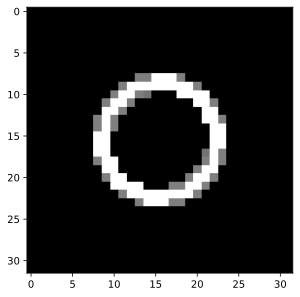

In [103]:
plt.imshow(bitmap)

### tile scan, tile id, and tile count

In [115]:
test_id = -2613818574377563994

In [116]:
Adjacency_rules = {t_id : [set(),set(),set(),set()] for t_id in tile_counts}


for t_id in tile_counts:
  for nb_id in tile_counts:

    # 0. irany : nyugat, bal -----------------------------
    a = get_tile_from_hash[t_id][:,:2,:]
    b = get_tile_from_hash[nb_id][:,1:,:]

    if np.all(a == b): #ha atfedesben van
      Adjacency_rules[t_id][0].add(nb_id)

    # 1. irany : kelet, jobb -----------------------------
    a = get_tile_from_hash[t_id][:,1:,:]
    b = get_tile_from_hash[nb_id][:,:2,:]

    if np.all(a == b): #ha atfedesben van
      Adjacency_rules[t_id][1].add(nb_id)

    # 2. irany : eszak, fel -----------------------------
    a = get_tile_from_hash[t_id][:2,:,:]
    b = get_tile_from_hash[nb_id][1:,:,:]

    if np.all(a == b): #ha atfedesben van
      Adjacency_rules[t_id][2].add(nb_id)

    # 3. irany : del, le -----------------------------
    a = get_tile_from_hash[t_id][1:,:,:]
    b = get_tile_from_hash[nb_id][:2,:,:]

    if np.all(a == b): #ha atfedesben van
      Adjacency_rules[t_id][3].add(nb_id)

In [117]:
nr_tiles = len(tile_counts)

# A : (melyik csempe, melyik szomszeddal, melyik iranyban) = szomszedos-e?
A = np.zeros((nr_tiles,nr_tiles,4), dtype = "bool")


for t_idx, t_id in enumerate(tile_counts):
  for nb_idx, nb_id in enumerate(tile_counts):
    a = get_tile_from_hash[t_id]
    b = get_tile_from_hash[nb_id]


    # 0. irany : nyugat, bal 
    if np.all(a[:,:2,:] == b[:,1:,:]): #ha atfedesben van
      A[t_idx, nb_idx, 0] = True

    # 1. irany : kelet, jobb 
    if np.all(a[:,1:,:] == b[:,:2,:]): 
      A[t_idx, nb_idx, 1] = True

    # 2. irany : eszak, fel 
    if np.all(a[:2,:,:] == b[1:,:,:]): 
      A[t_idx, nb_idx, 2] = True

    # 3. irany : del, le 
    if np.all(a[1:,:,:] == b[:2,:,:]): 
      A[t_idx, nb_idx, 3] = True


### creat output possibilities (`W`)

In [238]:
out_dims = (80,100)

In [239]:
id_to_idx = { id : n  for n, id in enumerate(tile_counts.keys()) }

In [240]:
W = np.ones((*out_dims, len(tile_counts)), dtype = "bool")

In [241]:
W.shape

(80, 100, 95)

### create entropy vec (`H`)

In [242]:
H = np.ones((out_dims), dtype = "float")

In [243]:
H[:,:] = len(tile_counts)

### observation

In [244]:
def observation(H, W):
  """
  1.find min entropy
  2.choose from possible tiles, according to input deviation

  returns (which index, what color)
  """
  #find min entropy
  i,j = np.unravel_index(H.argmin(), H.shape) # find argmin indices

  #choose from possible tiles, according to input deviation
  population = []
  weights = []
  for b, t_id in zip(W[i,j], id_to_idx):
    if b: # ha ez meg megengedett csempe
      population.append(t_id)
      weights.append(tile_counts[t_id])


  return (i,j), choices(population, weights=weights)[0]


### collapse, and create `output_image`

In [245]:
output_image = np.zeros((*out_dims, 3), dtype = "uint8")

In [246]:
def collapse(H,W, output_image):
  """
  1. get min entropy tile
  2. update W an H
  3. color output_image

  return the collapsed index (i,j)
  """

  #get min entropy tile 
  (i,j), t_id = observation(H, W) 

  #update W at this tile
  W[i,j, :] = False
  W[i,j, id_to_idx[t_id]] = True

  # set entropy to inf for the collapsed cell
  H[i,j] = float("inf")

  # color the (i,j) pixel in the output_image
  # with the left upper color of the coosen tile.
  output_image[i,j, :] = get_tile_from_hash[t_id][0,0,:] #

  return (i,j)

In [247]:
# for _ in range(6000):
#   collapse(H, W, output_image)

### propagation 🥸

In [248]:
def propagation(W, i,j):
  """
  start updating W from (i,j) using Adjacency_rules
  """
  
  stack = {(i,j)} #start from last recent collapsed cell

  while stack:

    idx_current = stack.pop() # a kozepso, akinek a szomszedait vizsgaljuk

    w,h = W.shape[1], W.shape[0]

    i,j = idx_current

    nbr_idxs = [(i, (j-1) % w), # 0. irany : nyugat, bal 
                (i, (j+1) % w), # 1. irany : kelet, jobb
                ((i-1) % h, j), # 2. irany : eszak, fel
                ((i+1) % h, j)  # 3. irany : del, le
                ]

    for dir, idx_nb in enumerate(nbr_idxs):

      if H[idx_nb] != float("inf"): #csak ha meg nem collapsed a nb
        
        possible_tiles_at_current = W[idx_current]
        
        possible_nbrs_at_dir = np.any( A[possible_tiles_at_current, :, dir],
                                      axis = 0)
        
        x,y = idx_nb
        available = W[x,y, :]

        # check if the neighbour is need to be updated at all
        # available is not subset of possible_nbrs_at_dir ?
        if not ( np.all( possible_nbrs_at_dir[available] )):

          intersection = possible_nbrs_at_dir & available

          if np.sum(intersection) == 0:
            print("nincs lehetseges csempe")
            return

          else:
            #update wave function at idx_nb
            W[x,y, :] = intersection

            # add nbr to stack
            stack.add(idx_nb)

In [ ]:
images = [Image.open(f"gif/out_{t}.png") for t in range(0,8001, 100)]

In [237]:
images[0].save('flower_out2.gif',
               save_all=True,
               append_images=images[1:],
               optimize=True,
               duration=4, loop=0)